In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# import wbgapi as wb

# import country_converter as coco
# import logging
# coco_logger = coco.logging.getLogger()
# coco_logger.setLevel(logging.CRITICAL)


In [2]:
datadir = Path("/mnt/d/openalex-bibliometrics-research/data/works_scopus_matched_parquet_5/")
fglob = datadir.glob('*.parquet')

In [3]:
def get_data_df(datadir, column: str, fillna=True, dropna=False, explode=False) -> pd.DataFrame:
    datadir = Path(datadir)
    if column == 'type':
        columns = ['work_id', 'in_match_set', 'publication_year', column]
    else:
        columns = ['work_id', 'in_match_set', 'publication_year', 'type', column]
    df = pd.concat([pd.read_parquet(fp, columns=columns) for fp in datadir.glob('*.parquet')])
    df = df[df['type']!='paratext']
    # if column != 'type':
    #     df = df.drop(columns=['type'])
    df = df.drop_duplicates(subset=['work_id'])
    df = df.dropna(subset=['in_match_set'])
    if dropna is True:
        df = df.dropna(subset=[column])
    if fillna is True:
        df[column] = df[column].fillna(value='Unknown')
    if explode is True:
        df = df.explode(column)
    return df


In [4]:
# RUN THIS CODE TO GET THE DATAFRAME FROM THE RAW DATA

df_type = get_data_df(datadir, 'type')
# we don't need the in_match_set column for this
df_type.drop(columns=['in_match_set'], inplace=True)

min_year = 2000
max_year = 2022
df_type = df_type[(df_type['publication_year']>=min_year)&(df_type['publication_year']<=max_year)]
df_work_type_by_year = df_type.groupby(['publication_year', 'type']).size()
df_work_type_by_year = df_work_type_by_year.reset_index(name='n_works')
# rename the columns to work with Juan's code
columns_rename = {
    'publication_year': 'year',
    'type': 'key_display_name',
}
df_work_type_by_year = df_work_type_by_year.rename(columns=columns_rename)

In [5]:
filename = "counts_by_year/df_work_type_by_year.csv"

# RUN THIS CODE TO SAVE THE DATAFRAME FROM THE ABOVE CELL FOR FUTURE USE
df_work_type_by_year.to_csv(filename, index=False)


# # RUN THIS CODE INSTEAD TO LOAD THE PRESAVED DATAFRAME
# df_work_type_by_year = pd.read_csv(filename)

In [6]:
# RUN THIS CODE TO GET THE DATAFRAME FROM THE RAW DATA

df_source_type = get_data_df(datadir, 'source_type')
# we don't need the in_match_set column for this
df_source_type.drop(columns=['in_match_set'], inplace=True)

min_year = 2000
max_year = 2022
df_source_type = df_source_type[(df_source_type['publication_year']>=min_year)&(df_source_type['publication_year']<=max_year)]
# restrict to articles
df_article_source_type = df_source_type[df_source_type['type']=='article']
df_article_source_type_by_year = df_article_source_type.groupby(['publication_year', 'source_type']).size()
df_article_source_type_by_year = df_article_source_type_by_year.reset_index(name='n_works')
# rename the columns to work with Juan's code
columns_rename = {
    'publication_year': 'year',
    'source_type': 'key_display_name',
}
df_article_source_type_by_year = df_article_source_type_by_year.rename(columns=columns_rename)
# Change the key_display_name to have 'article-' in it, so that we can sort it out when merged with previous
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: 'article-%s' % x)

# identify the most common source types, and change all the other source types to 'article-other' 
# ! note: in Juan's code, this was top_3_types, but using the method in this code, the unknowns are already present and not added later, so it's changed to top_4_types to get the same output
top_4_types = set(df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(4).index)
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: x if x in top_4_types else 'article-other')
# lowercase
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.str.lower()
# ! Note: the below code was needed for the data gathered from the API, but it is not needed for this method

# # Some messy code to merge both and then calculate how many Source Type "unknown" 
# # This is because # articles is greater than the Sum of the Group by Source Type (filtered by article)
# tmp = df_work_type_by_year[df_work_type_by_year.key_display_name == 'article'].merge(df_article_source_type_by_year.groupby('year').sum(), left_on='year', right_on='year')
# tmp['n_works'] = tmp['n_works_x'] - tmp['n_works_y']
# tmp = tmp[['year', 'n_works']]
# # tmp['key'] = 'https://openalex.org/source-types/unknown'  # not really using, but to match up when concatenating
# tmp['key_display_name'] = 'article-unknown'
# df_article_source_type_by_year = pd.concat([df_article_source_type_by_year, tmp])
# del tmp


In [7]:
filename = "counts_by_year/df_article_source_type_by_year.csv"

# RUN THIS CODE TO SAVE THE DATAFRAME FROM THE ABOVE CELL FOR FUTURE USE
df_article_source_type_by_year.to_csv(filename, index=False)


# # RUN THIS CODE INSTEAD TO LOAD THE PRESAVED DATAFRAME
# df_article_source_type_by_year = pd.read_csv(filename)

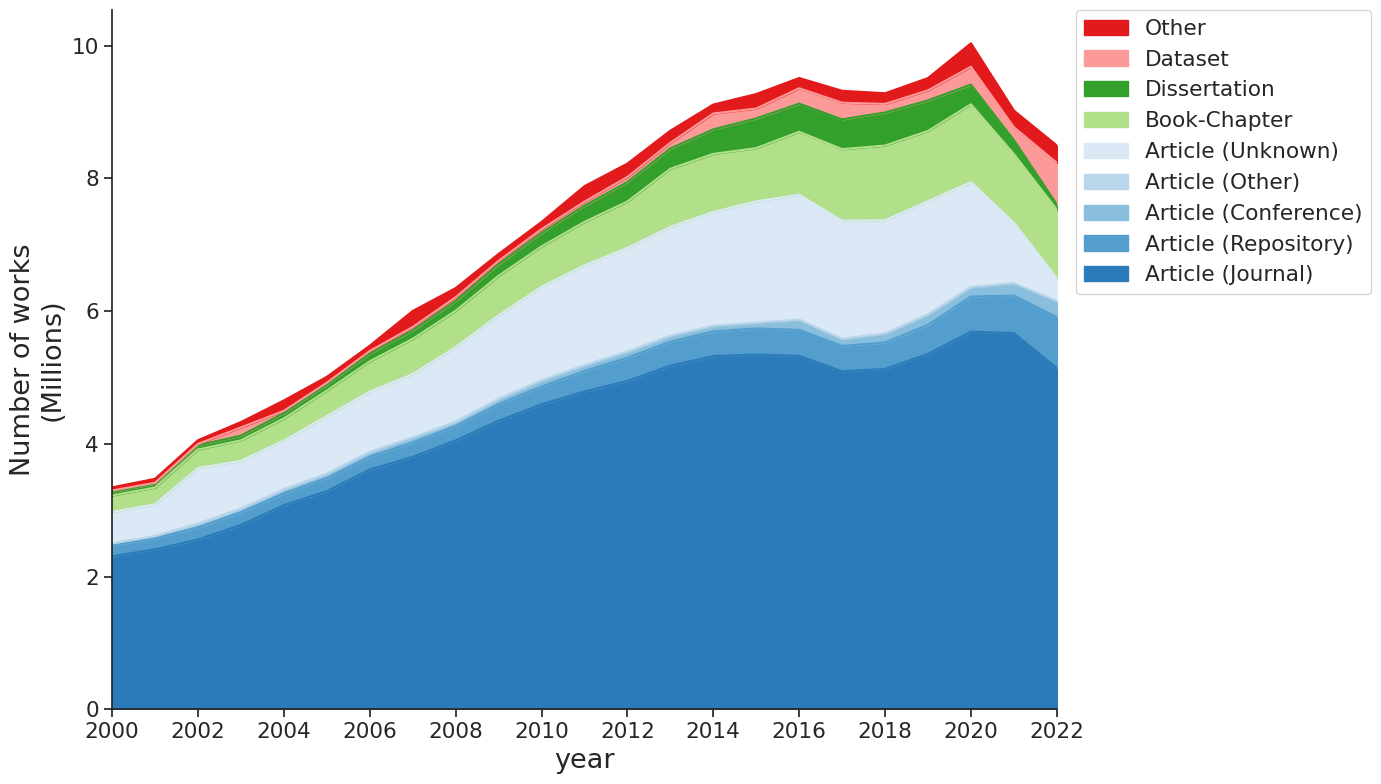

In [8]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
blues = list(reversed(sns.color_palette("Blues")[0:5]))
color = blues + sns.color_palette("Paired")[2:]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

top_5_types = set(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(5).index)

data = df_work_type_by_year
data['key_display_name'] = data.key_display_name.map(lambda x: x if x in top_5_types else 'other')
# data.loc['key_display_name'] = data.key.map(lambda x: x if x != 'https://openalex.org/types/other' else 'other')


data = data[data.key_display_name != 'article']
data = pd.concat([data, df_article_source_type_by_year])

data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
# data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index
order = ['article-journal', 'article-repository', 'article-conference', 'article-other', 'article-unknown', 'book-chapter', 'dissertation', 'dataset', 'other']
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='area', color=color, ax=ax)

ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])

handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    if l.startswith('article'):
        l = "{} ({})".format(l.split('-')[0], l.split('-')[1])
    return l.title()


plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('Figure 1. Number of Works per Year by Type and Subtype.png')



In [9]:
p_articles = df_work_type_by_year.groupby('key_display_name').sum()['n_works'].divide(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().sum()).multiply(100)['article']
p_journal_articles = (df_article_source_type_by_year.groupby('key_display_name').sum()['n_works'] / df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("There are {:.1f}M works in OpenAlex published between 2000 and 2022, with a peak of {:.1f}M works published in {}.".
      format(df_work_type_by_year['n_works'].sum()/1000000,  df_work_type_by_year.groupby('year')['n_works'].sum().max()/1000000, df_work_type_by_year.groupby('year')['n_works'].sum().idxmax()))
print("The majority ({:.0f}%) of these works are classified as articles and, of these articles, the majority ({:.0f}%) are found in journals.".format(p_articles, p_journal_articles))


There are 168.2M works in OpenAlex published between 2000 and 2022, with a peak of 10.2M works published in 2020.
The majority (82%) of these works are classified as articles and, of these articles, the majority (73%) are found in journals.


In [10]:
p_articles = (df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name').sum()['n_works'] / df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article']
p_journal_articles = (df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum() / df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("The proportion classified as articles changes only slightly (to {:.0f}%) when considering only the most recent 10 years.".format(p_articles))


The proportion classified as articles changes only slightly (to 79%) when considering only the most recent 10 years.


In [11]:
# RUN THIS CODE TO GET THE DATAFRAME FROM THE RAW DATA

df_country = get_data_df(datadir, 'countries', explode=True)
# we don't need the in_match_set column for this
df_country.drop(columns=['in_match_set'], inplace=True)

min_year = 2000
max_year = 2022
df_country = df_country[(df_country['publication_year']>=min_year)&(df_country['publication_year']<=max_year)]
# Variable name is inconsistent here, but keeping it like this to better align with Juan's code
df_work_type_by_year = df_country.groupby(['publication_year', 'countries']).size()
df_work_type_by_year = df_work_type_by_year.reset_index(name='n_works')
# rename the columns to work with Juan's code
columns_rename = {
    'publication_year': 'year',
    'countries': 'key_display_name',
}
df_work_type_by_year = df_work_type_by_year.rename(columns=columns_rename)

# drop Unknowns
df_work_type_by_year = df_work_type_by_year[df_work_type_by_year['key_display_name']!='Unknown']

top_10_countries = set(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(10).index)
df_work_type_by_year = df_work_type_by_year[df_work_type_by_year['key_display_name'].isin(top_10_countries)]
display_name_map = {'US': 'United States of America',
 'GB': 'United Kingdom of Great Britain and Northern Ireland',
 'JP': 'Japan',
 'DE': 'Germany',
 'FR': 'France',
 'CN': 'China',
 'CA': 'Canada',
 'IT': 'Italy',
 'BR': 'Brazil',
 'IN': 'India'}
df_work_type_by_year['key_display_name'] = df_work_type_by_year['key_display_name'].map(display_name_map)

In [12]:
filename = "counts_by_year/df_country_by_year.csv" # see note about variable name above

# RUN THIS CODE TO SAVE THE DATAFRAME FROM THE ABOVE CELL FOR FUTURE USE
df_work_type_by_year.to_csv(filename, index=False)


# # RUN THIS CODE INSTEAD TO LOAD THE PRESAVED DATAFRAME
# df_work_type_by_year = pd.read_csv(filename)

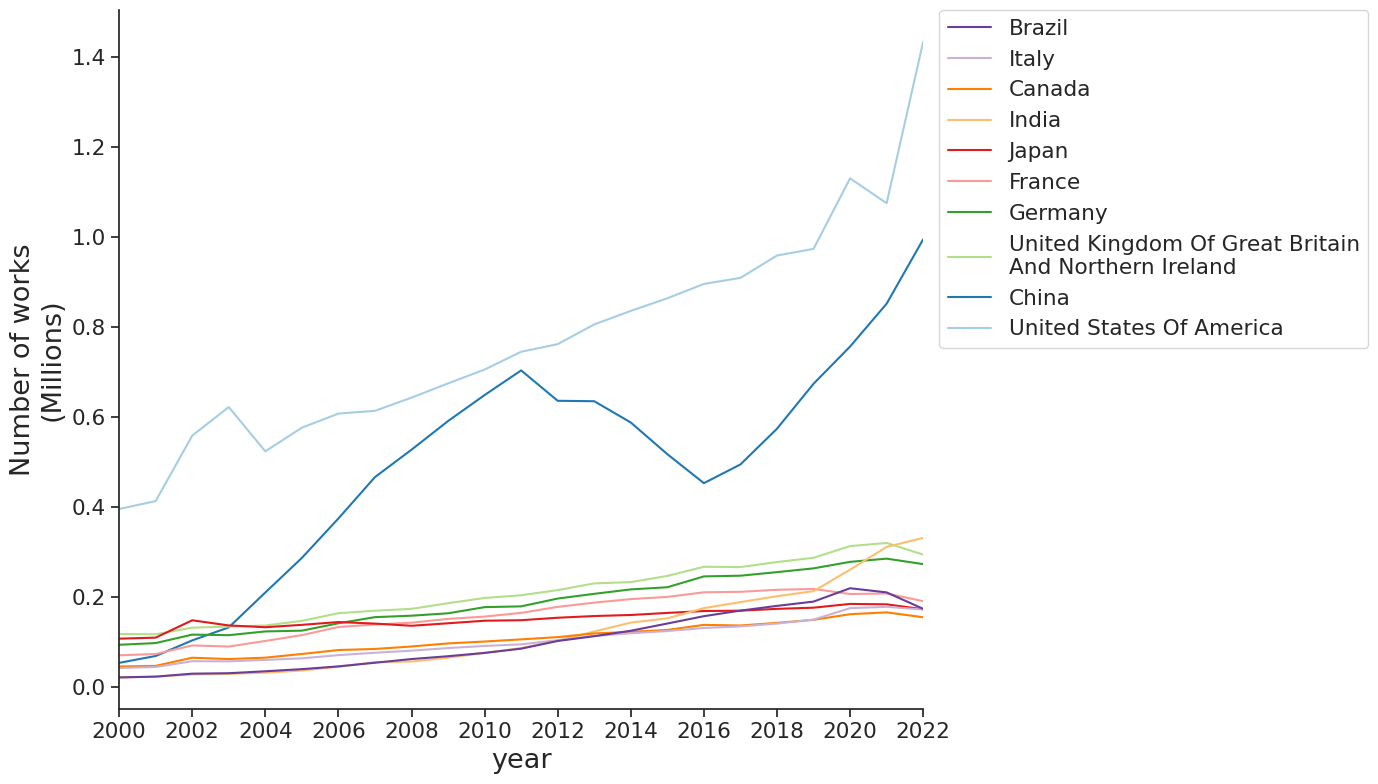

In [13]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 * font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)

color = sns.color_palette("Paired")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


data = df_work_type_by_year
data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
order = list(data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index)
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='line', color=color, ax=ax)


ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])

handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    return l.replace(' and', '\nand').title()

plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('Figure 2. Number of Works per Year by Country.png')

